# Random Forests

In [3]:
%load_ext autoreload
%autoreload 2

# Random Forests

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error


from preprocess import data

np.random.seed(0)


In [5]:
x_tl = data["x_timed_lagged"].reset_index(drop=True).shift(1)
x_germany = data["x_germany"].reset_index(drop=True)
x_austria = data["x_austria"].reset_index(drop=True)
y_germany = data["y_germany"].reset_index(drop=True)
y_austria = data["y_austria"].reset_index(drop=True)

In [6]:
X_ger = pd.concat([x_germany, x_tl], axis=1).dropna().drop(columns=["DATE_FROM"]).reset_index(drop=True) #drop the first row of the df due to .shift(1)
X_aust = pd.concat([x_austria, x_tl], axis=1).dropna().drop(columns=["DATE_FROM"]).reset_index(drop=True)

y_ger = y_germany.iloc[1:].reset_index(drop=True)
y_aus = y_austria.iloc[1:].reset_index(drop=True)

## Classical Random Forest

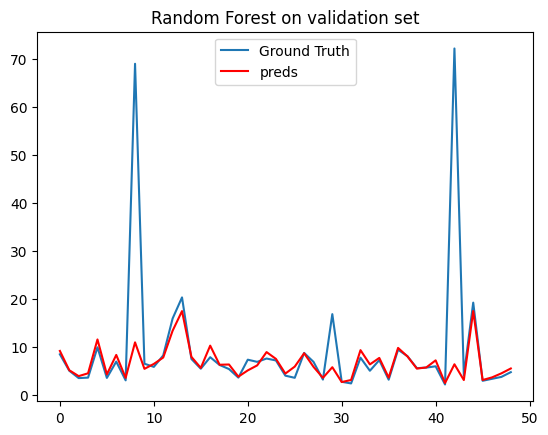

Mean Squared Error: 161.10382785489801


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_ger, y_ger, test_size=0.2)

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_valid)

# Evaluate the model
plt.plot(y_valid.reset_index(drop=True), label='Ground Truth')
plt.plot(y_pred, color='red', label='preds')
plt.title("Random Forest on validation set")
plt.legend()
plt.show()

mse = mean_squared_error(y_valid.reset_index(drop=True), y_pred)
print(f'Mean Squared Error: {mse}')

## Without split

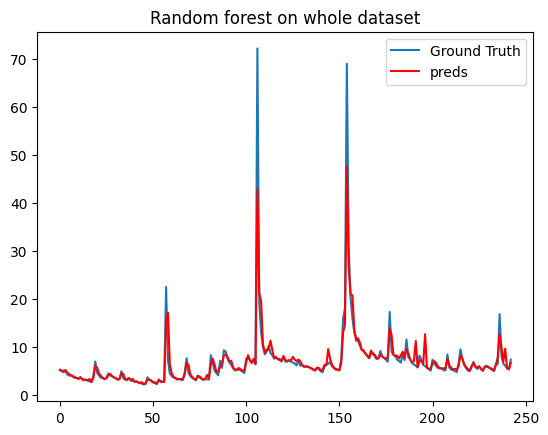

Mean Squared Error: 7.337916132057604


In [18]:


model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_ger, y_ger)

# Make predictions on the test set
y_pred = model.predict(X_ger)

# Evaluate the model
plt.plot(y_ger, label='Ground Truth')
plt.plot(y_pred, color='red', label='preds')
plt.title('Random forest on whole dataset')
plt.legend()
plt.show()

mse = mean_squared_error(y_ger.reset_index(drop=True), y_pred)
print(f'Mean Squared Error: {mse}')

## Dynamic Random Forest

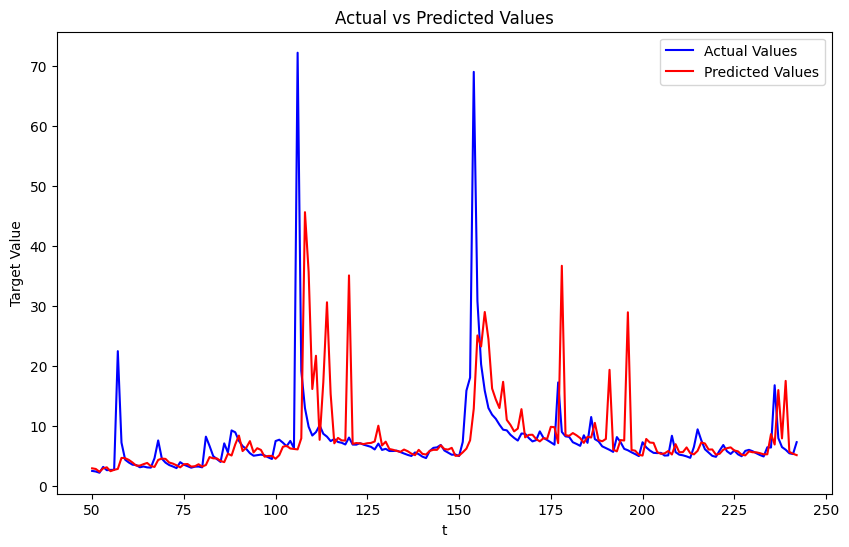

In [19]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

X = X_ger
y = y_ger

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42, bootstrap=True)

# Lists to store the actual and predicted values
actual_values = []
predicted_values = []

# Loop over t from 50 to the length of the dataset
for t in range(50, len(X)):
    # Split the data
    X_train = X[:t]
    y_train = y[:t]
    X_test = X.iloc[[t]]  # Reshape to 2D array for prediction

    # Train the model
    model.fit(X_train, y_train)

    # Make prediction on the t-th sample
    y_pred = model.predict(X_test)
    
    # Store the actual and predicted values
    actual_values.append(y[t])
    predicted_values.append(y_pred[0])

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(50, len(X)), actual_values, label='Actual Values', color='blue')
plt.plot(range(50, len(X)), predicted_values, label='Predicted Values', color='red')
plt.xlabel('t')
plt.ylabel('Target Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## Random Forest with ridge

In [15]:


model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=20)

model.fit(X_ger, y_ger)

# Make predictions on the test set
y_pred = model.predict(X_ger)

leaf_indices = model.apply(X_ger)
unique_leaves = np.unique(leaf_indices)

ridge_models = {}

for leaf in unique_leaves:
    indices = np.where(leaf_indices == leaf)
    print(indices)
    X_leaf = X_ger.iloc[indices]
    y_leaf = y_ger.iloc[indices]
    ridge = Ridge()
    ridge.fit(X_leaf, y_leaf)
    ridge_models[leaf] = ridge

leaf_indices_valid = model.apply(X_valid)
y_pred = np.zeros_like(y_ger)

for i, leaf in enumerate(leaf_indices_valid):
    ridge = ridge_models[leaf]
    y_pred[i] = ridge.predict(X_valid.iloc[[i]])[0]
    

# Tracer les valeurs réelles et les prédictions
plt.plot(y_ger.reset_index(drop=True), label='Ground Truth')
plt.plot(y_pred, color='red', label='Predictec')
plt.title('CART + RIDGE')
plt.legend()
plt.show()

# Visualiser l'arbre de régression
from sklearn.tree import plot_tree

plot_tree(model, filled=True, rounded=True)
plt.show()


# Evaluate the model
plt.plot(y_ger, label='Ground Truth')
plt.plot(y_pred, color='red', label='preds')
plt.title('Random forest on whole dataset')
plt.legend()
plt.show()


mse = mean_squared_error(y_ger.reset_index(drop=True), y_pred)
print(f'Mean Squared Error: {mse}')

(array([57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
       57, 57, 57]), array([ 0,  1,  6, 10, 11, 25, 29, 37, 40, 41, 43, 46, 52, 53, 65, 82, 89,
       90, 96, 97]))


IndexError: positional indexers are out-of-bounds